# Forecasting Diaper Demand

Brendan Reed  
12/9/2025

### Import Packages

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math

### Import Data

In [2]:
df = pd.read_csv("data/diapers.csv")

df.head()

,Timestamp,BRANCH,ZIP CODE,SIZE,# PACKS,SIZE.1,# PACKS.1,SIZE.2,# PACKS.2,TOTAL,DATE,MONTH,YEAR,DAY,WEEKDAY
0,9/7/2021 0:00:00,GG,63011,1,3.0,NaN,NaN,NaN,NaN,3,September 2021,September,2021,7,Tue
1,9/7/2021 0:00:00,GG,63011,3T,2.0,NaN,NaN,NaN,NaN,2,September 2021,September,2021,7,Tue
2,9/14/2021 0:00:00,GG,63118,5,2.0,NaN,NaN,NaN,NaN,2,September 2021,September,2021,14,Tue
3,9/14/2021 0:00:00,GG,63118,6,2.0,NaN,NaN,NaN,NaN,2,September 2021,September,2021,14,Tue
4,9/14/2021 0:00:00,GG,63125,5,2.0,NaN,NaN,NaN,NaN,2,September 2021,September,2021,14,Tue


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59425 entries, 0 to 59424
Data columns (total 15 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Timestamp  50120 non-null  object 
 1   BRANCH     50117 non-null  object 
 2   ZIP CODE   50113 non-null  object 
 3   SIZE       49967 non-null  object 
 4   # PACKS    50090 non-null  float64
 5   SIZE.1     7687 non-null   object 
 6   # PACKS.1  7595 non-null   float64
 7   SIZE.2     1648 non-null   object 
 8   # PACKS.2  2491 non-null   float64
 9   TOTAL      59425 non-null  int64  
 10  DATE       59425 non-null  object 
 11  MONTH      50120 non-null  object 
 12  YEAR       50120 non-null  object 
 13  DAY        50120 non-null  object 
 14  WEEKDAY    50120 non-null  object 
dtypes: float64(3), int64(1), object(11)
memory usage: 6.8+ MB


## Cleaning Data

Choose only desired columns

In [4]:
df = df[[
    'Timestamp', 'BRANCH', 'ZIP CODE', 'SIZE', '# PACKS', 'SIZE.1',
    '# PACKS.1', 'SIZE.2', '# PACKS.2', 'TOTAL'
]]

Make all column names lower case

In [5]:
df.columns = [item.lower() for item in list(df.columns)]

Filter to only Weber Road

In [6]:
df = df[df['branch'] == "WR"]

Create a row for each pair of sizes and # packs

In [7]:
size_cols = ["size", "size.1", "size.2"]
pack_cols = ["# packs", "# packs.1", "# packs.2"]

pieces = []

for i in range(3):  # force 3 iterations
    temp = df[["timestamp", "branch", "zip code"]].copy()
    temp["size"] = df[size_cols[i]]
    temp["# packs"] = df[pack_cols[i]]
    pieces.append(temp)

df = pd.concat(pieces, ignore_index=True)


Drop rows where both size and # packs is NA

In [8]:
df = df.dropna(subset=["size", "# packs"], how="all")

Preview data

In [9]:
df.head()

,timestamp,branch,zip code,size,# packs
0,9/3/2021 0:00:00,WR,63125,6,2.0
1,9/3/2021 0:00:00,WR,63123,3,2.0
2,9/7/2021 0:00:00,WR,63125,4,2.0
3,9/7/2021 0:00:00,WR,63118,n,6.0
4,9/7/2021 0:00:00,WR,63118,n,3.0


Check for missing values

In [10]:
pd.DataFrame({
    "NaN Count": df.isna().sum(),
    "Total Rows": len(df),
    "Percent NaN": df.isna().mean() * 100
})


,NaN Count,Total Rows,Percent NaN
timestamp,0,12506,0.000000
branch,0,12506,0.000000
zip code,4,12506,0.031985
size,444,12506,3.550296
# packs,25,12506,0.199904


See unique sizes

In [11]:
list(df["size"].unique())

['6',
 '3',
 '4',
 'n',
 '2',
 '3t',
 '1',
 '5',
 'N',
 '3T',
 '2T',
 '2t',
 'adult',
 '4t',
 '4T',
 nan,
 '7']

Some sizes have duplicates or are not valid.  
Fixes: 
- 'n' and 'N' need to be combined
- 2t and 2T need to be combined for pullups (same with 3t/3T and 4t/4T)
- size 7 needs to be added to nan (we do not give out size 7)

In [12]:
# cast all sizes to strings
df['size'] = df['size'].astype(str)

# make all letters in df["size"] upper case
df["size"] = [x.upper() for x in df["size"]]

# replace size 7 with "Not a Number"
df["size"] = df["size"].replace("7", "NAN")

Now there should be no duplicates of sizes.

In [13]:
list(df["size"].unique())

['6', '3', '4', 'N', '2', '3T', '1', '5', '2T', 'ADULT', '4T', 'NAN']

Create date and month columns

In [14]:
# convert timestamp column to datetime
df['timestamp'] = pd.to_datetime(df['timestamp'])

# create month column
df['month'] = df['timestamp'].dt.to_period('M')

# create date column
df['date'] = pd.to_datetime(df['timestamp']).dt.date

# remove timestamp column
df = df.drop('timestamp', axis=1)


Create pivot table to see totals for each size by month

In [15]:
# Replace real NaN in size with a category name
df['size_cat'] = df['size'].astype('object').fillna('NaN')

# Build pivot table
table = df.pivot_table(
    index='month',
    columns='size_cat',
    values='# packs',
    aggfunc='sum',
    fill_value=0,
    dropna=False   # <-- keeps all categories
)




In [16]:
table['total'] = table.sum(axis=1)
table['adj total'] = table['total'] - table['NAN']
table['month2'] = table.index.month
table['year'] = table.index.year
table['adj total 2'] = table['total'] - (table['NAN'] + table['2T'] + table['3T'] + table['4T'] + table['ADULT'])

In [17]:
table.head()

size_cat,1,2,2T,3,3T,4,4T,5,6,ADULT,N,NAN,total,adj total,month2,year,adj total 2
month,,,,,,,,,,,,,,,,,
1902-10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,2.0,2.0,10,1902,2.0
2021-09,9.0,15.0,0.0,18.0,6.0,24.0,0.0,20.0,16.0,0.0,15.0,0.0,123.0,123.0,9,2021,117.0
2021-10,9.0,14.0,6.0,27.0,6.0,27.0,0.0,48.0,30.0,0.0,15.0,0.0,182.0,182.0,10,2021,170.0
2021-11,14.0,28.0,2.0,39.0,2.0,34.0,0.0,44.0,42.0,0.0,12.0,0.0,217.0,217.0,11,2021,213.0
2021-12,31.0,30.0,0.0,43.0,4.0,32.0,0.0,46.0,50.0,0.0,12.0,0.0,248.0,248.0,12,2021,244.0


In [18]:
table_filtered = table[(table.index.year >=2023)].copy()

Drop December 2025 - incomplete data

In [19]:
table_filtered = table_filtered.loc[table_filtered.index != '2025-12-01']

In [20]:
# Convert PeriodIndex to Timestamp for plotting
table_filtered.index = table_filtered.index.to_timestamp()

In [21]:
# preview pivot table
table_filtered["NAN/total"] = round(table_filtered["NAN"] / table_filtered["total"], 2)

In [22]:
table_filtered.head()

size_cat,1,2,2T,3,3T,4,4T,5,6,ADULT,N,NAN,total,adj total,month2,year,adj total 2,NAN/total
month,,,,,,,,,,,,,,,,,,
2023-01-01,8.0,17.0,5.0,36.0,2.0,61.0,1.0,66.0,100.0,1.0,3.0,0.0,300.0,300.0,1,2023,291.0,0.0
2023-02-01,6.0,11.0,5.0,24.0,4.0,43.0,0.0,79.0,79.0,0.0,4.0,0.0,255.0,255.0,2,2023,246.0,0.0
2023-03-01,11.0,15.0,5.0,42.0,2.0,48.0,5.0,61.0,92.0,0.0,6.0,0.0,287.0,287.0,3,2023,275.0,0.0
2023-04-01,9.0,13.0,5.0,33.0,6.0,35.0,0.0,66.0,83.0,0.0,8.0,0.0,258.0,258.0,4,2023,247.0,0.0
2023-05-01,12.0,11.0,2.0,31.0,12.0,54.0,0.0,58.0,108.0,0.0,11.0,0.0,299.0,299.0,5,2023,285.0,0.0


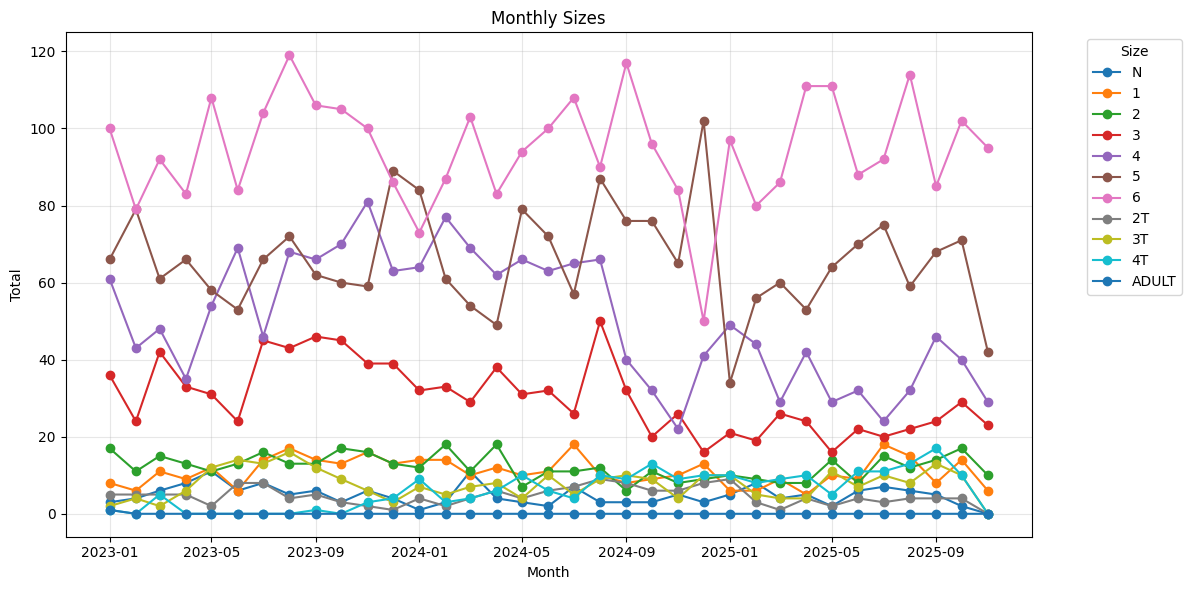

In [23]:
size_cols = ['N', '1', '2', '3', '4', '5', '6', '2T', '3T', '4T', 'ADULT']

plt.figure(figsize=(12,6))

for col in size_cols:
    plt.plot(table_filtered.index, table_filtered[col], marker='o', label=col)

plt.title('Monthly Sizes')
plt.xlabel('Month')
plt.ylabel('Total')
plt.legend(title='Size', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

Create pivot table that shows proportions of each size to monthly totals

In [24]:
size_cols = ['N', '1', '2', '3', '4', '5', '6', '2T', '3T', '4T', 'ADULT']


# Create a new DataFrame for proportions
prop_table = table_filtered[size_cols].div(table_filtered['adj total'], axis=0)

# Round to 2 decimals for readability
prop_table = prop_table.round(2)

<Figure size 1200x600 with 0 Axes>

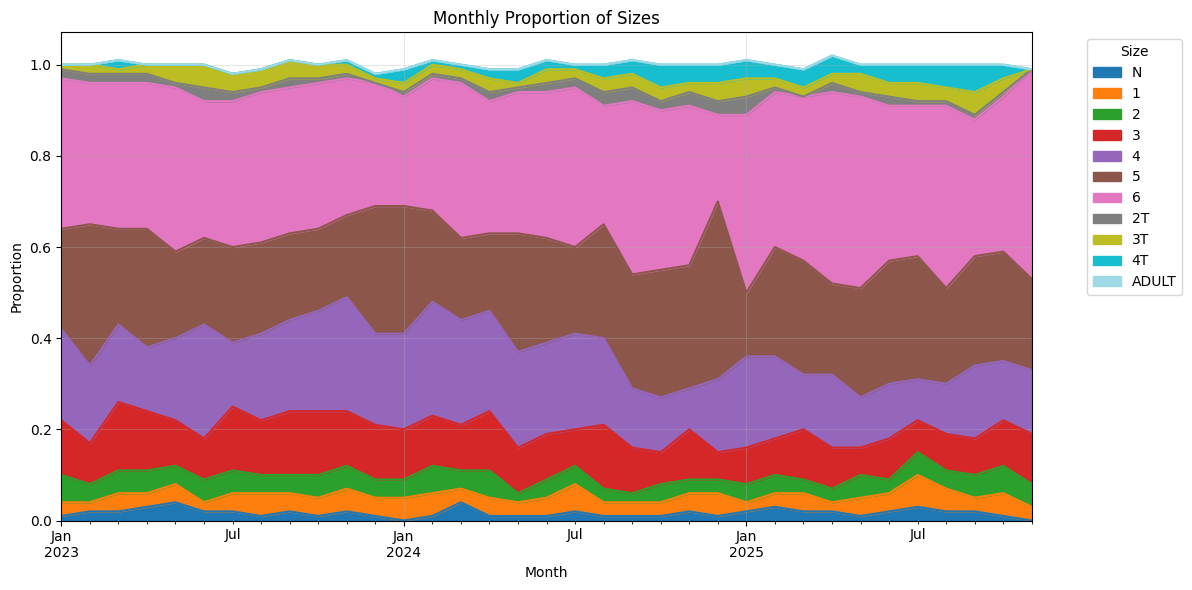

In [25]:
plt.figure(figsize=(12,6))

# stacked area plot
prop_table.plot(kind='area', stacked=True, figsize=(12,6), cmap='tab20')

plt.title('Monthly Proportion of Sizes')
plt.xlabel('Month')
plt.ylabel('Proportion')
plt.legend(title='Size', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

In [26]:
# Total area (sum of proportions over all months)
total_area = prop_table[size_cols].sum()

total_area_percent = (total_area / total_area.sum())

Overall diaper size proportions from 2023 - 2025

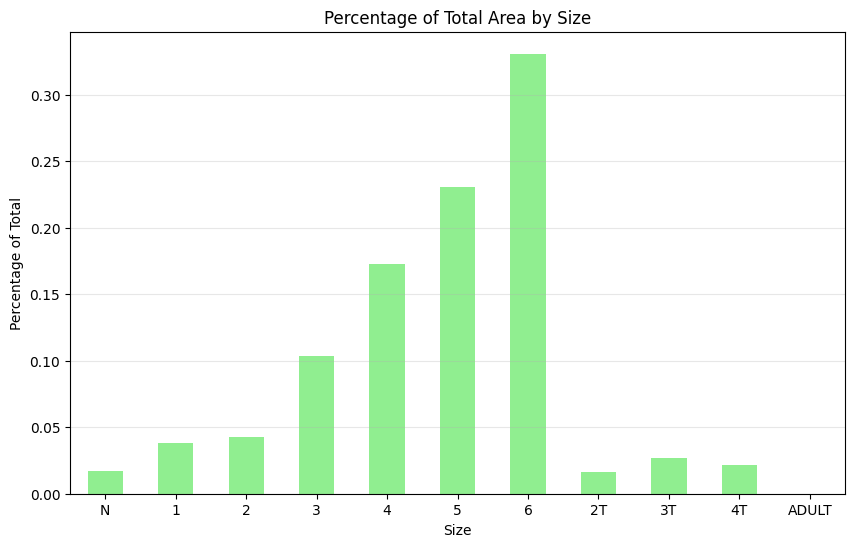

In [27]:
total_area_percent.plot(kind='bar', figsize=(10,6), color='lightgreen')

plt.title('Percentage of Total Area by Size')
plt.xlabel('Size')
plt.ylabel('Percentage of Total')
plt.xticks(rotation=0)
plt.grid(axis='y', alpha=0.3)
plt.show()


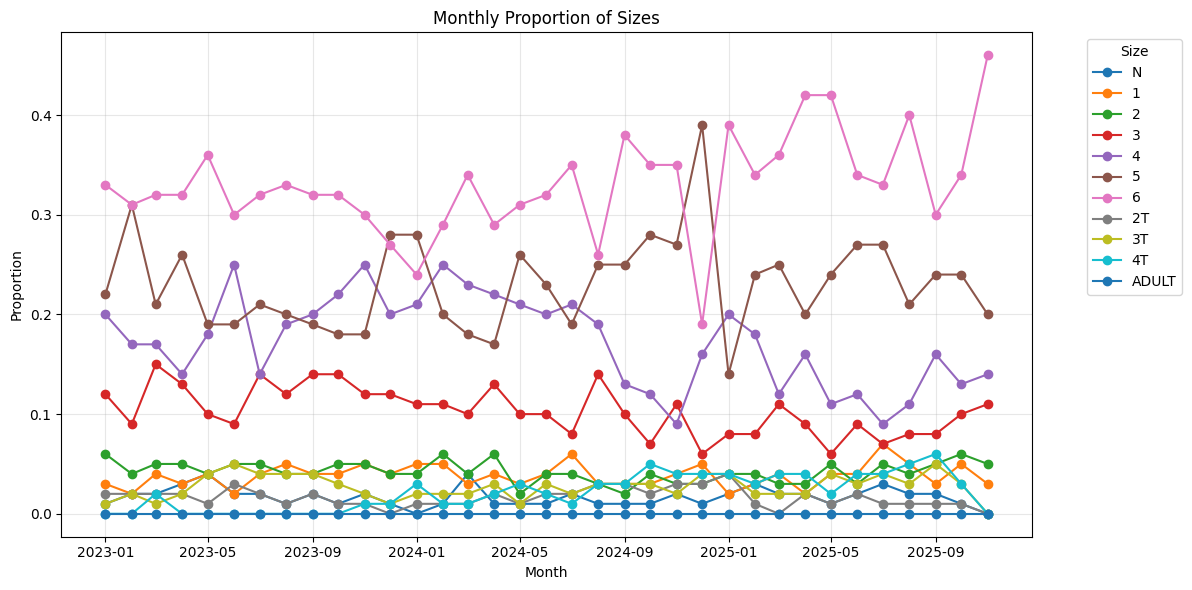

In [28]:
plt.figure(figsize=(12,6))

for col in size_cols:
    plt.plot(prop_table.index, prop_table[col], marker='o', label=col)

plt.title('Monthly Proportion of Sizes')
plt.xlabel('Month')
plt.ylabel('Proportion')
plt.legend(title='Size', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


In [29]:
prop_table.loc[["2023-01-01", "2025-11-01"],:]

size_cat,N,1,2,3,4,5,6,2T,3T,4T,ADULT
month,,,,,,,,,,,
2023-01-01,0.01,0.03,0.06,0.12,0.20,0.22,0.33,0.02,0.01,0.0,0.0
2025-11-01,0.00,0.03,0.05,0.11,0.14,0.20,0.46,0.00,0.00,0.0,0.0


### Conclusions:
Size 6 has seen an upward trend proportionally, while other sizes have seen downward trends. At some points, less size 6 diapers are given out than size 5. This is probably due to running out of size 6 and people choosing size 5 instead. For the biggest size 6 dip in late 2024, the data point could be removed and interpolated, which could improve forcasting.

Options for generalizing proportions to the future:
- Look at total proportions for only the last 12 months
- Try to predict linear trends in proportions  

Use cases:
- Proportions could be used to fill in missing values for diaper sizes
- After total diapers distributed is predicted for future months, the total can be multiplied with proportions for sizes to predict number of sizes given out each month

Create pivot table showing diaper totals by month for each year

In [30]:
totals_by_month = table_filtered.pivot_table(
    index='month2',
    columns='year',
    values='total',
    aggfunc='sum'
)

totals_by_month.loc[12,2025] = np.nan

In [31]:
totals_by_month
pivot = totals_by_month
pivot.head()

year,2023,2024,2025
month2,,,
1,300.0,300.0,270.0
2,255.0,303.0,267.0
3,287.0,302.0,250.0
4,258.0,286.0,294.0
5,299.0,308.0,290.0


Graph monthly totals by year to compare trends

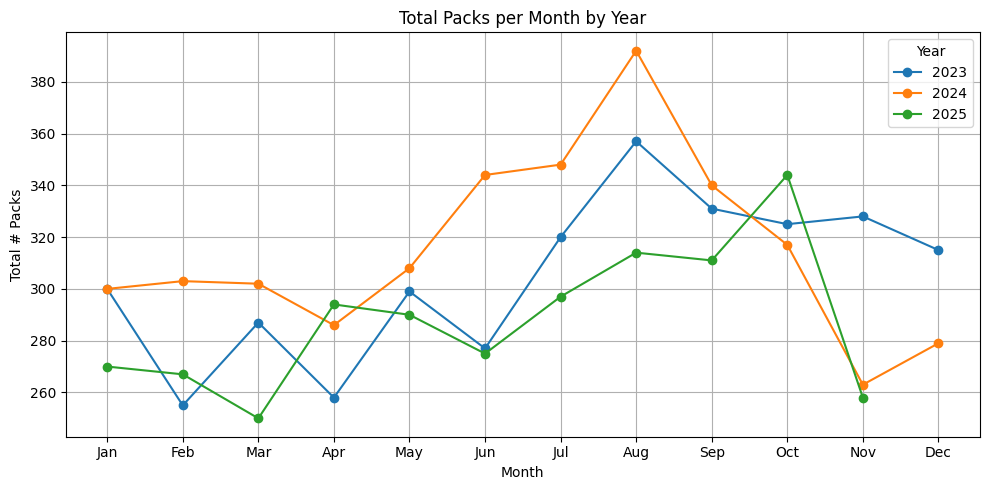

In [32]:
plt.figure(figsize=(10,5))
for year in totals_by_month.columns:
    plt.plot(totals_by_month.index, totals_by_month[year], marker='o', label=str(year))

plt.xlabel("Month")
plt.ylabel("Total # Packs")
plt.title("Total Packs per Month by Year")
plt.xticks(ticks=range(1,13), labels=[
    "Jan","Feb","Mar","Apr","May","Jun","Jul","Aug","Sep","Oct","Nov","Dec"
])
plt.legend(title="Year")
plt.grid(True)
plt.tight_layout()
plt.show()


Conclusion: 2023, 2024, and 2025 follow similar seasonal trends. Totals increase in summer and decrease in winter.

## Creating Models

### Modeling Total Diapers per Month

About holt-winters...

Deciding between Additive and Multiplicative

In [33]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

# Flatten table to time series (Month-Year index)
ts = pivot.stack()
ts.index = pd.date_range(start='2023-01-01', periods=len(ts), freq='MS')

# Additive Holt-Winters
model_add = ExponentialSmoothing(ts, trend='add', seasonal='add', seasonal_periods=12).fit()

# Multiplicative Holt-Winters
model_mul = ExponentialSmoothing(ts, trend='add', seasonal='mul', seasonal_periods=12).fit()

print("Additive AIC:", model_add.aic)
print("Multiplicative AIC:", model_mul.aic)

Additive AIC: 252.76239663602357
Multiplicative AIC: 251.14781997365506


Conclusion: go with multiplicative

In [34]:
table_filtered.loc["2025-12-01","total"] = np.nan

In [35]:
# Create a pandas Series for the totals
ts = table_filtered["total"].sort_index()  # make sure sorted by date
ts = ts.interpolate(method='time')

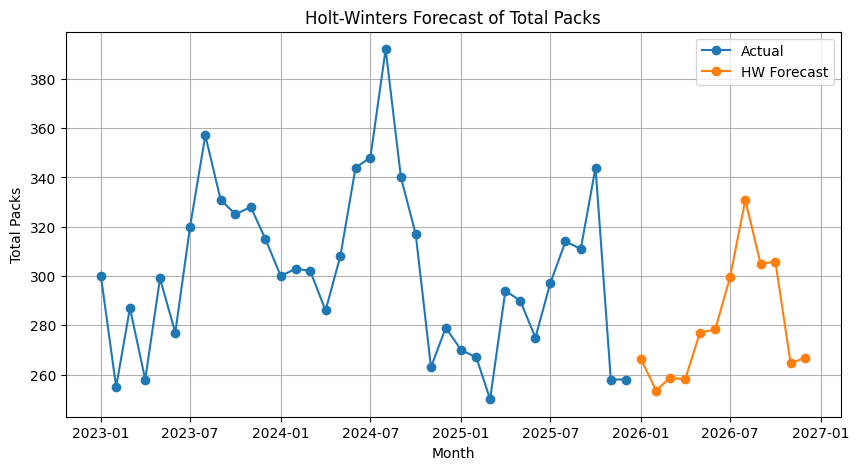

In [36]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import matplotlib.pyplot as plt

# Fit Holt-Winters seasonal model (monthly data, yearly seasonality)
hw_model = ExponentialSmoothing(ts, seasonal='mul', seasonal_periods=12)
hw_fit = hw_model.fit()

# Forecast next 12 months
hw_forecast = hw_fit.forecast(12)

# Plot
plt.figure(figsize=(10,5))
plt.plot(ts.index, ts, label='Actual', marker='o')
plt.plot(hw_forecast.index, hw_forecast, label='HW Forecast', marker='o')
plt.title('Holt-Winters Forecast of Total Packs')
plt.xlabel('Month')
plt.ylabel('Total Packs')
plt.legend()
plt.grid(True)
plt.show()


## Storage

In [37]:
storage = pd.read_csv("data/storage.csv", index_col=0)

storage["Proportion"] = round(storage["Total"] / sum(storage["Total"]), 2)

storage

,Total,Proportion
Shelf,,
N,15,0.03
1,63,0.13
2,63,0.13
3,90,0.19
4,60,0.13
5,60,0.13
6,120,0.25


In [38]:
size_cols = ['N', '1', '2', '3', '4', '5', '6']


# Create a new DataFrame for proportions
prop_table = table_filtered[size_cols].div(table_filtered['adj total 2'], axis=0)

# Round to 2 decimals for readability
prop_table = prop_table.round(2)

# only look at the past year
subset = prop_table.loc["2024-12-01":"2025-11-01"]

In [39]:
# Total area (sum of proportions over all months)
total_area = subset[size_cols].sum()

total_area_percent = round(total_area / total_area.sum(),2)

Find average packs per month given out

In [40]:
df = table_filtered[size_cols].loc['2024-12-01':'2025-11-01']

In [41]:
averages = [math.ceil(x) for x in df.mean()]

In [42]:
storage["Est. Loss/Month"] = averages
storage["Est. Loss/Month Prop."] = total_area_percent

In [43]:
storage[["Total", "Est. Loss/Month", "Proportion", "Est. Loss/Month Prop."]]

,Total,Est. Loss/Month,Proportion,Est. Loss/Month Prop.
Shelf,,,,
N,15,5,0.03,0.02
1,63,10,0.13,0.04
2,63,12,0.13,0.05
3,90,22,0.19,0.09
4,60,37,0.13,0.15
5,60,63,0.13,0.26
6,120,93,0.25,0.39


In [44]:
storage['New Stock'] = storage['Total'].sum() * storage["Est. Loss/Month Prop."]

In [45]:
storage['New Stock'] = [math.ceil(x) for x in storage['New Stock']]

In [46]:
storage

,Total,Proportion,Est. Loss/Month,Est. Loss/Month Prop.,New Stock
Shelf,,,,,
N,15,0.03,5,0.02,10
1,63,0.13,10,0.04,19
2,63,0.13,12,0.05,24
3,90,0.19,22,0.09,43
4,60,0.13,37,0.15,71
5,60,0.13,63,0.26,123
6,120,0.25,93,0.39,184


In [54]:
# table for how many months we could last with our shelves fully stocked
current = storage['Total']
current_months = round(storage['Total'] / storage['Est. Loss/Month'], 1)
new = storage["New Stock"]
new_months = round(storage["New Stock"] / storage['Est. Loss/Month'], 1)

df = pd.DataFrame({
    'current': current,
    'current_months': current_months,
    'new': new,
    'new_months': new_months
})

df


,current,current_months,new,new_months
Shelf,,,,
N,15,3.0,10,2.0
1,63,6.3,19,1.9
2,63,5.2,24,2.0
3,90,4.1,43,2.0
4,60,1.6,71,1.9
5,60,1.0,123,2.0
6,120,1.3,184,2.0


Use proportions to estimate missing data

In [47]:
table_filtered.head()

size_cat,1,2,2T,3,3T,4,4T,5,6,ADULT,N,NAN,total,adj total,month2,year,adj total 2,NAN/total
month,,,,,,,,,,,,,,,,,,
2023-01-01,8.0,17.0,5.0,36.0,2.0,61.0,1.0,66.0,100.0,1.0,3.0,0.0,300.0,300.0,1.0,2023.0,291.0,0.0
2023-02-01,6.0,11.0,5.0,24.0,4.0,43.0,0.0,79.0,79.0,0.0,4.0,0.0,255.0,255.0,2.0,2023.0,246.0,0.0
2023-03-01,11.0,15.0,5.0,42.0,2.0,48.0,5.0,61.0,92.0,0.0,6.0,0.0,287.0,287.0,3.0,2023.0,275.0,0.0
2023-04-01,9.0,13.0,5.0,33.0,6.0,35.0,0.0,66.0,83.0,0.0,8.0,0.0,258.0,258.0,4.0,2023.0,247.0,0.0
2023-05-01,12.0,11.0,2.0,31.0,12.0,54.0,0.0,58.0,108.0,0.0,11.0,0.0,299.0,299.0,5.0,2023.0,285.0,0.0


Look at weekly breakdowns

See what the damage is from the first two weeks, then order to replenish